# Toy convex high condition number exp

what about keep track of  |g_t - g_{t-1}| / max(|g_t|, |g_{t-1}|) or |g_t - g_{t-1}| / |m_t|? 

thus 

effective_lr = lr * |m_t| / |g_t - g_{t-1}| 

that is  lr * |m_t| / |g_t - g_{t-1}| * m_t v.s. lr * |m_t| / |g_t - g_{t-1}| * sign(m_t) # the latter being mc

The problem with the latter logic is that |g_t - g_{t-1}| can at most be 2 times of m_t on expectation (since beta2 > beta1 is actually larger, but on a similar scale), which makes decreasing lr too hard, but increasing lr is easy. The effect is that for large lr, MC and adam cannot adjust back. To deal with this issue, 

The problem of the former logic is that m_t are very small. It suffers the same problem as SGD.

Why this is better? 

lr m_t / (|g_t - g_{t-1}| / |w_t - w_{t-1}|) = lr |w_t - w_{t-1}| / |g_t - g_{t-1}| * m_t = 

effective_lr * lr * |m_{t-1}| / |g_t - g_{t-1}| * m_t

thus 

effective_lr = effective_lr * (lr * |m_{t-1}| / |g_t - g_{t-1}|)

b/c w_t - w_{t-1} = effective_lr * m_{t-1} 

the above the better because if (lr * |m_{t-1}| / |g_t - g_{t-1}|) becomes small or 0 for even once, effective lr cannot recover (becomes 0 ever since)! To solve this, we add a minimal learning rate 1e-8 to aid it adjust back. But it still suffers the case where m is too small.

I like

TODO: try a version of momentum where it can only speed up when curvature is small and never slow down below lr

try lr * |min(g_t, g_{t-1}) / (g_t - g_{t-1})| * sign(m_t) but this is too noisy, not working
try no normalization lr / |g_t - g_{t-1}| * sign(m_t), not working b/c denominator small 

points of suspicion

1. beta2 > beta1 forces adam be more conservative with step size
2. keeping square term makes adam remember large update more thus being more conservative with step size
4. try effective_lr = effective_lr * (lr * |m_{t-1}| / |g_t - g_{t-1}|) but with sign so not double going to 0
5. try effective_lr = effective_lr * (lr / |g_t - g_{t-1}|) with sign and with mt

The advantage of 4 and 5 is that we don't have to buy in the idea of linear with curvature update, but they don't work as they rely heavily on the choice of the threshold hyper parameter.

In [194]:
import torch
import numpy as np

# create a problem with controlled condition number
kappa = 10**4 # condition number to vary

d = 50 # feature dimension, keep this <= n so that condition number is finite
n = 300 # number of observations

x_star = np.random.randn(d)
x_star = x_star / np.linalg.norm(x_star)

b = np.random.randn(n)
b = 0.1 * b / np.linalg.norm(b); 

noise = np.random.randn(n)
noise = noise / np.linalg.norm(noise) * 1e-3

# data matrix
A = 1/np.sqrt(n) * np.random.randn(n, d)
U, S, Vh = np.linalg.svd(A) # np.allclose(U[:,:len(S)].dot(np.diag(S)).dot(Vh), A) gives True

# change the eigenvalues
log_smin = -1 # that is mu = 0.1**2
log_smax = np.log10(np.sqrt(kappa) * 10**log_smin) 
S = np.logspace(log_smin, log_smax, d)[::-1]

A = U[:,:len(S)].dot(np.diag(S)).dot(Vh)
y = A.dot(x_star) + noise #+ b 

''' verify kappa'''
import matplotlib.pyplot as plt
_,S_,_ = np.linalg.svd(A.T.dot(A))
print('empirical \mu={:.2f}, L={:.2f}'.format(np.min(S_), np.max(S_)))

mu = (10**log_smin)**2
L = kappa * mu
print(r'theoretical \mu={:.2f}, L={:.2f}, \kappa={:.2f}'.format(mu, L, L/mu))
# this is not axis aligned

empirical \mu=0.01, L=100.00
theoretical \mu=0.01, L=100.00, \kappa=10000.00


In [228]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import tqdm
from lib.utils import OptRecorder
from lib.optimizer import Diff, Avrng, AdamVR, MomentumCurvature, NormalizedCurvature, Sign, MomentumCurvature2
from lib.optimizer import NormalizedCurvature2, CurvatureSign, RCSign, EffectiveMCSign, MomentumCurvature3
from lib.optimizer import Adam3, SecondMoment, DoubleMomentum, AlphaAdam, AlphaSGD, AlphaDiff, AlphaDiff2
from lib.optimizer import AdaBound, CrossBound, CrossVarSGD, CrossAdaSGD, CrossAdaBound, Swats
import copy

def train(net, loader, full_loader, optimizer, niters=800, ntrack=10, LSR=True, patience=10, cheat=False): 
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience,
                                                           verbose=True, factor=0.5)
    opt_recorder = OptRecorder(optimizer, ntrack)
    errors = []

    cheat_loader = copy.deepcopy(full_loader)
    for _ in tqdm.tqdm(range(niters)):
        for x, y in loader:
            if cheat:
                x, y = next(iter(cheat_loader))
            
            x, y = x.cuda(), y.cuda()
            if not LSR:
                y = (y>0).long()
            
            def closure():
                optimizer.zero_grad()
                o = net(x)
                if LSR:
                    l = nn.MSELoss()(o.view(-1), y)
                else:
                    l = nn.CrossEntropyLoss()(o, y)
                l.backward()
                return l
            optimizer.step(closure)
            opt_recorder.record()
            
            for x, y in full_loader:
                x, y = x.cuda(), y.cuda()
                o = net(x)
                if LSR:
                    l = nn.MSELoss()(o.view(-1), y)
                else:
                    y = (y>0).long()
                    l = nn.CrossEntropyLoss()(o, y)
                errors.append(l.item())
                scheduler.step(l.item())

            p = list(net.parameters())[0].cpu().detach().numpy().ravel()
            #errors.append(np.linalg.norm(p - x_star))

    return errors, opt_recorder.tracker

LSR = True
#errors = {}
#tracker = {}
# best for adam like 0.1, for alphasgd is 10
lr = 0.1 # 0.01 # 1 / L / 100 #* 10000 #/ 100 # 2/(L+mu) # 0.01
niters = 3000 #1500
batch_size = 300 #300
patience = 10000
print('lr={:.5f}'.format(lr))
data = TensorDataset(torch.from_numpy(A).float(), torch.from_numpy(y).float())
loader = DataLoader(data, batch_size=batch_size)
full_loader = DataLoader(data, batch_size=n)

for opt in ['Swats']: 
    print(opt)   
    if LSR: # logistic regression
        net = nn.Linear(d, 1, bias=True)
    else:
        net = nn.Linear(d, 2, bias=True)
    net.cuda()
    net.weight.data = torch.zeros_like(net.weight.data) # zero initialize
    
    cheat = False
    if opt == 'cheat':
        print('in cheat mode')
        cheat = True
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    elif opt == 'CrossAdaBound': 
        print('in cross ada bound')
        optimizer = eval(opt)(net.parameters(), lr=lr)        
    elif opt == 'CrossAdaSGD': 
        print('in cross ada sgd')
        optimizer = eval(opt)(net.parameters(), lr=lr, final_lr=(0.1 / lr)**-1)
    elif opt == 'EffectiveMCSign':
        print('in ems')
        optimizer = eval(opt)(net.parameters(), lr=lr, threshold=3)
    elif opt == 'AlphaDiff' or opt == 'AlphaDiff2': # 10
        print('in alpha diff')
        optimizer = eval(opt)(net.parameters(), lr=lr, alphas=(1, 1))                
    elif opt == 'AlphaSGD': # 10
        print('in alpha sgd')
        optimizer = eval(opt)(net.parameters(), lr=lr, alphas=(1e-6, 0.9), eps=0)        
    elif opt == 'AlphaAdam': # 0.1
        print('in alpha adam')
        optimizer = eval(opt)(net.parameters(), lr=lr, alphas=(1, 1))
    elif opt == 'MomentumCurvature3':
        print('in mc')
        optimizer = eval(opt)(net.parameters(), lr=5e-3, betas=(0.9, 0.999, 0.5))        
    elif opt == 'MomentumCurvature':
        print('in mc')
        optimizer = eval(opt)(net.parameters(), lr=1e-1)
    elif opt == 'torch.optim.Adam':
        print('in adam')
        optimizer = eval(opt)(net.parameters(), lr=lr, eps=1e-8)        
    elif opt == 'Adam3':
        print('in adam')
        optimizer = eval(opt)(net.parameters(), lr=5e-2)    
    elif opt == 'NormalizedCurvature2':
        print('in NC')        
        optimizer = eval(opt)(net.parameters(), lr=lr, betas=(0.9, 0.9))
    elif opt == 'torch.optim.SGD':
        print('in SGD')
        optimizer = eval(opt)(net.parameters(), lr=1.5, momentum=0.9)
    else:
        print('in else')
        optimizer = eval(opt)(net.parameters(), lr=lr)
    name = opt.split('.')[-1]
    errors[name], tracker[name] = train(net, loader, full_loader,
                                        optimizer, LSR=LSR, niters=niters,
                                        patience=patience,
                                        cheat=cheat)

  0%|          | 9/3000 [00:00<00:34, 85.60it/s]

lr=0.10000
Swats
in else


100%|██████████| 3000/3000 [00:30<00:00, 97.75it/s]


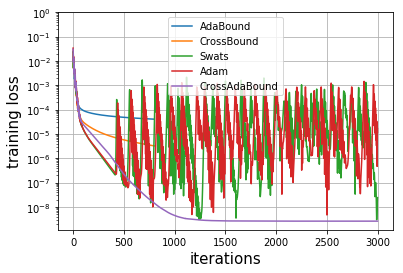

In [229]:
# batch size 300
from lib.utils import smooth
import matplotlib.pyplot as plt

for k, e in errors.items():
    #if k in ['AlphaSGD', 'AlphaAdam', 'Adam', 'MomentumCurvature', 'SGD', 'AlphaDiff']:
    if k in ['Swats', 'Adam', 'CrossBound', 'SGD', 'AdaBound', 'CrossAdaBound', 'CrossAdaSGD']:
        plt.semilogy(smooth(e,1), label=k)
    #plt.plot(smooth(e,1), label=k)
#plt.ylabel(r'$\Vert x-x^* \Vert_2$', fontsize=15)
plt.ylabel(r'training loss', fontsize=15)
plt.legend()
plt.xlabel('iterations', fontsize=15)
plt.grid()
plt.ylim([None,1])
plt.show()

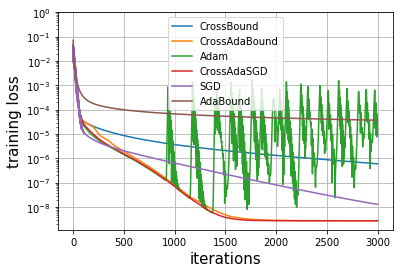

In [291]:
# batch size 300
from lib.utils import smooth
import matplotlib.pyplot as plt

for k, e in errors.items():
    #if k in ['AlphaSGD', 'AlphaAdam', 'Adam', 'MomentumCurvature', 'SGD', 'AlphaDiff']:
    if k in ['Adam', 'CrossBound', 'SGD', 'AdaBound', 'CrossAdaBound', 'CrossAdaSGD']:
        plt.semilogy(smooth(e,1), label=k)
    #plt.plot(smooth(e,1), label=k)
#plt.ylabel(r'$\Vert x-x^* \Vert_2$', fontsize=15)
plt.ylabel(r'training loss', fontsize=15)
plt.legend()
plt.xlabel('iterations', fontsize=15)
plt.grid()
plt.ylim([None,1])
plt.show()

plotting Swats


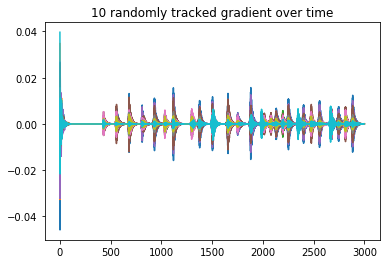

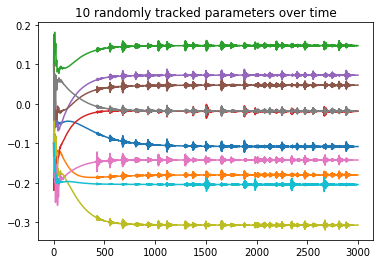

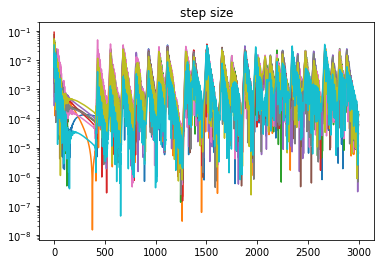

/home/jiaxuan/venv/lib/python3.5/site-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


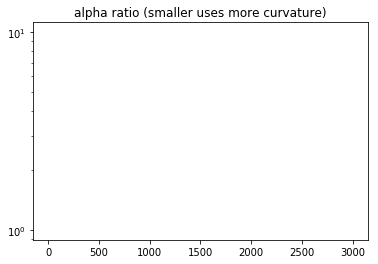

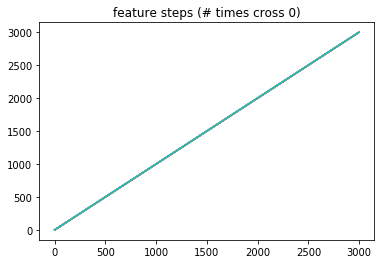

In [230]:
import matplotlib.pyplot as plt

def plot_tracker(track, param_index):
    ntrack = len(track[param_index]['grad'])

    for i in range(ntrack):
        g = np.array(track[param_index]['grad'][i])
        plt.plot(g)
    plt.title('{} randomly tracked gradient over time'.format(ntrack))
    plt.show()

    for i in range(ntrack):
        g = np.array(track[param_index]['param'][i])
        plt.plot(g)
    plt.title('{} randomly tracked parameters over time'.format(ntrack))
    plt.show()

    for i in range(ntrack):
        p = np.array(track[param_index]['param'][i])
        diff = p[1:] - p[:-1]
        plt.semilogy(np.abs(diff)) # negative b/c gradient "descent"
    plt.title('step size')
    plt.show()

    for i in range(ntrack):
        p = np.array(track[param_index]['alpha_ratio'][i])
        plt.semilogy(p)
    plt.title('alpha ratio (smaller uses more curvature)')
    plt.show()

    for i in range(ntrack):
        p = np.array(track[param_index]['feature_step'][i])
        plt.plot(p)
    plt.title('feature steps (# times cross 0)')
    plt.show()

name = 'Swats'
print('plotting {}'.format(name))
plot_tracker(tracker[name], param_index=0)


plotting CrossAdaBound


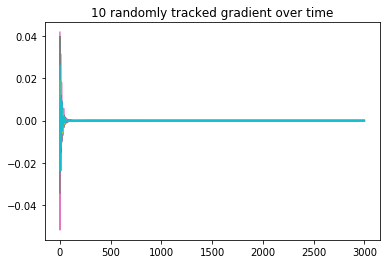

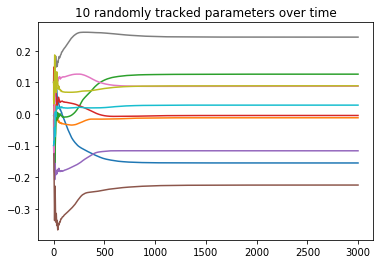

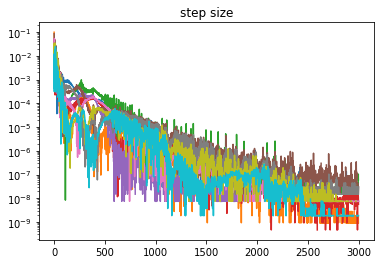

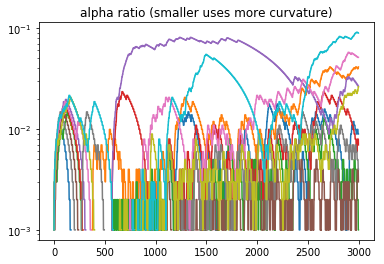

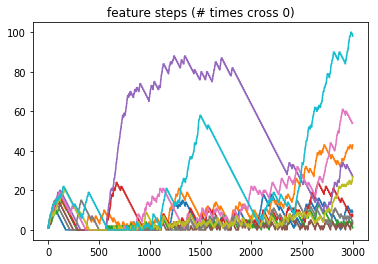

In [227]:
name = 'CrossAdaBound'
print('plotting {}'.format(name))
plot_tracker(tracker[name], param_index=0)


# linear regression result

In [345]:
# plot best learning rate for (method, batch_size, kappa)
import glob
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import numpy as np
import os
from lib.utils import smooth

def plot_best(kappa, batch_size, 
              ylim=None, 
              criteria=lambda x: True, 
              index_dir='synthetic_data_results/LSR',
              smooth_window=1,
              up_to=-1, # how many iterations to plot
              methods=None,
              show=True):
    
    # build index if not exist
    if not os.path.exists('{}/index.txt'.format(index_dir)):
        ind = {}
        # build an index based on kappa and batch_size
        for fn in tqdm.tqdm(glob.glob('{}/*.ind'.format(index_dir))):
            data = joblib.load(fn)
            if data['kappa'] not in ind:
                ind[data['kappa']] = {}
            if data['batch_size'] not in ind[data['kappa']]:
                ind[data['kappa']][data['batch_size']] = []
            ind[data['kappa']][data['batch_size']].append(fn[:-4])
        joblib.dump(ind, '{}/index.txt'.format(index_dir))
        
    ind = joblib.load('{}/index.txt'.format(index_dir))

    res = {}
    res_fns = {}
    for fn in ind[kappa][batch_size]:
        data = joblib.load('{}/{}.ind'.format(index_dir, fn.split('/')[-1]))
        if data['opt'].startswith('torch'):
            name = data['opt'].split('.')[-1]
        else:
            name = data['opt']
        if not criteria(data):
            continue
        if methods and name not in methods:
            continue
        if not res.get(name): 
            res[name] = {}
            res_fns[name] = {}
        if not res[name].get(data['lr']):
            res[name][data['lr']] = []
            res_fns[name][data['lr']] = []
        loss = joblib.load('{}/{}.loss'.format(index_dir, fn.split('/')[-1]))
        res[name][data['lr']].append(smooth(loss, smooth_window)[:up_to])
        res_fns[name][data['lr']].append(fn)
    print('done processing data')
    
    # sort to get best learning rate
    for name, v in sorted(res.items(), key=lambda x: x[0]): # sort by name
        lr, _ = sorted([(lr, np.mean([np.log(val) for val in vals])) for lr, vals in v.items()], 
                       key=lambda k: k[1])[0]
        p = plt.semilogy(np.percentile(v[lr], 50, 0), label='{}_{}'.format(name, lr))
        plt.semilogy(np.percentile(v[lr], 25, 0), alpha=0.5, c=p[-1].get_color())
        plt.semilogy(np.percentile(v[lr], 75, 0), alpha=0.5, c=p[-1].get_color())

    plt.ylabel('training loss', fontsize=15)
    plt.legend()
    plt.ylim(ylim)
    plt.xlabel('Epoch', fontsize=15)
    plt.grid()
    if show:
        plt.show()
    return res_fns
    
# report result for different method and learning rate
#track_files = plot_best(1, 50, up_to=1000, methods=['AdamC1'], 
#                       criteria=lambda data: data['lr']==1e-2)

done processing data
done processing data
done processing data
done processing data
done processing data
done processing data
done processing data
done processing data
done processing data


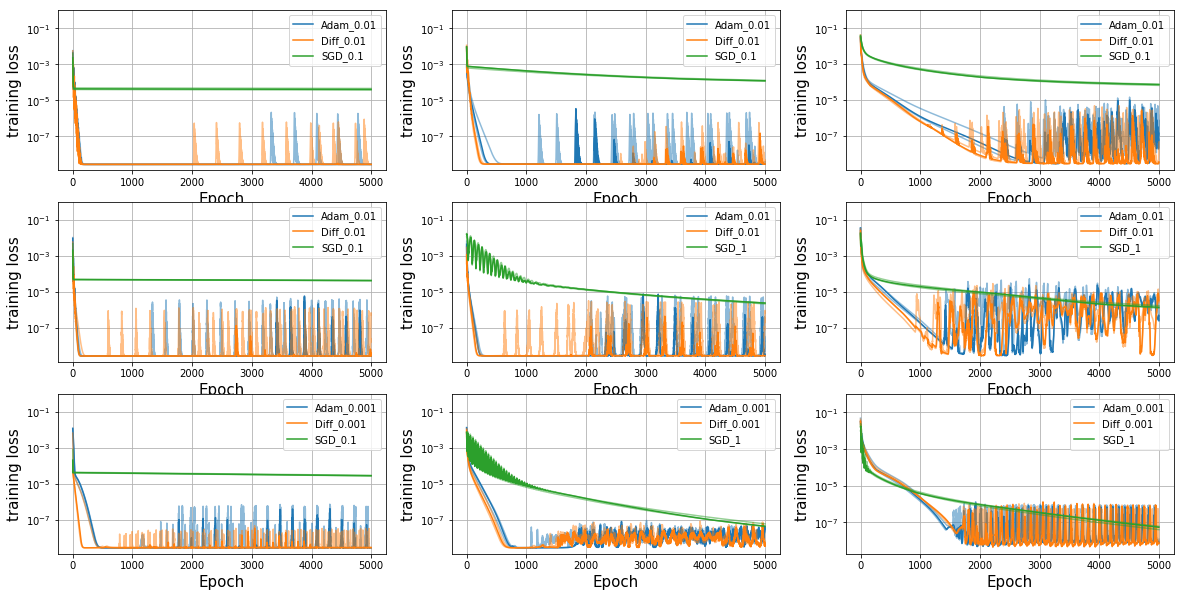

In [348]:
# methods = ['AdamC1(1,1)', 'Adam', 'AdamC2(1,1)'] # which variance to use?
# methods = ['AlphaDiff(1,1)', 'AlphaAdam(1,1)', 'SGD'] # what to use?
methods = ['Adam', 'Diff', 'SGD'] # what to use
# methods = ['AlphaDiff(1,1)', 'AlphaDiff(0,1)', 'AlphaDiff(1,0)'] # what is dominant
# methods = ['AlphaAdam(1,1)', 'AlphaAdam(0,1)', 'AlphaAdam(1,0)'] # what is dominant
# methods = ['Swats', 'AdaBound', 'CrossAdaBound', 'CrossBound'] # when to switch?
# methods = ['AlphaDiff(1,1)', 'AlphaAdam(1,1)', 'Swats'] # best comparison

up_to = 5000
plt.figure(figsize=(20, 10))
batch_sizes = [300, 150, 50]
kappas = [1, 100, 10**4]
for row, batch_size in enumerate(batch_sizes):
    for col, kappa in enumerate(kappas):
        plt.subplot(len(batch_sizes), len(kappas), row * len(kappas) + col + 1)
        track_files = plot_best(kappa, batch_size, show=False, #criteria=lambda data: data['lr'] == 1e-3,
                                methods=methods, ylim=[None,1], up_to=up_to)

plt.show()

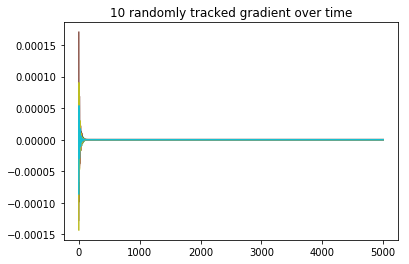

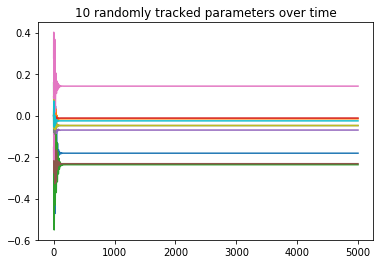

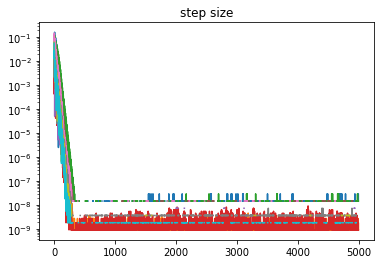

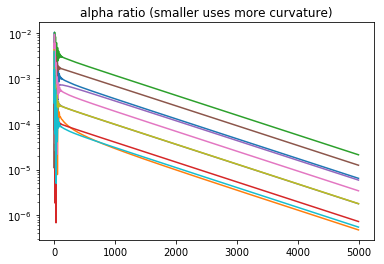

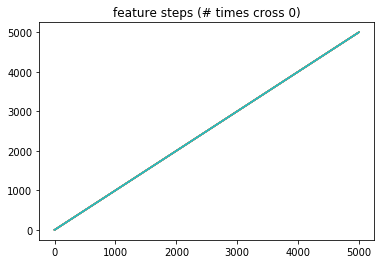

In [25]:
track = joblib.load(track_files['AdamC1(1,1)'][1][0] + '.track')
plot_tracker(track, 0)

# working setting on subset of CIFAR10

SGD: 98.96% (0.02) 3 runs
Diff: 98.87% (0.02) 2 runs
Adam: 98.83% (0.04) 2 runs


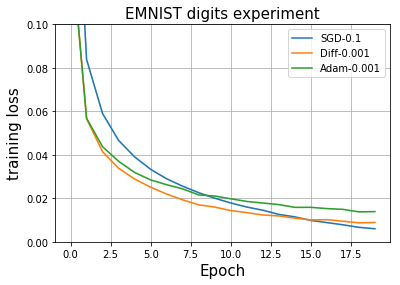

In [349]:
import glob
import matplotlib.pyplot as plt
from lib.utils import smooth
from sklearn.externals import joblib
import numpy as np

def plot_best(pattern, smooth_window=1, title=None, ylim=None, xlim=None, 
              methods=None, method2label=None, lr=None, report_result=False):
    methods_settings = {}
    accs = {}
    for fn in sorted(glob.glob(pattern)):
        method_setting = fn.split('/')[-1].split('^')[0].split('-')
        method, setting = method_setting[0], '-'.join(method_setting[1:])
        
        if lr is not None and lr != float(method_setting[1]):
            continue
        if methods is not None and method not in methods:
            continue
        
        if method not in methods_settings:
            methods_settings[method] = {}
            accs[method] = {}
        if setting not in methods_settings[method]:
            methods_settings[method][setting] = []
            accs[method][setting] = []
        
        tr_loss = smooth(joblib.load(fn), smooth_window)
        #if len(tr_loss)==10: print(fn)
            
        methods_settings[method][setting].append(tr_loss)
        accs[method][setting].append(float(fn.split('/')[-1].split('^')[1]))
        
    if len(methods_settings.keys()) > 1: # plot the best one, smallest area under the curve
        for method, setting_dict in methods_settings.items():
            setting_areas = []
            for setting, v in setting_dict.items():
                # find the smallest area
                area = np.sum(np.mean(v))
                setting_areas.append((setting, area))
            setting = sorted(setting_areas, key=lambda x: x[1])[0][0]
            v = setting_dict[setting]
            print('{}: {:.2f}% ({:.2f}) {} runs'.format(method, np.mean(accs[method][setting]), 
                                                np.std(accs[method][setting]),
                                                len(accs[method][setting])))
            
            if method2label is None:
                label = method + '-' + setting
            else:
                label = method2label.get(method, method)
            #p = plt.plot(sum(v) / len(v), label=method + '-' + setting)#, c=colors[i])            
            p = plt.plot(np.percentile(v, 50, 0), label=label)
            plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=p[-1].get_color())
            plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=p[-1].get_color())
                        
    else: # plot all
        for method, setting_dict in methods_settings.items():
            for setting, v in setting_dict.items():                
                print('{}: {:.2f}% ({:.2f}) {} runs'.format(method, np.mean(accs[method][setting]), 
                                                            np.std(accs[method][setting]), 
                                                            len(accs[method][setting])))
                
                if method2label is None:
                    label = method + '-' + setting
                else:
                    label = method2label.get(method,method) + '-' + setting
                
                p = plt.plot(np.percentile(v, 50, 0), label=label)
                plt.plot(np.percentile(v, 25, 0), alpha=0.1, c=p[-1].get_color())
                plt.plot(np.percentile(v, 75, 0), alpha=0.1, c=p[-1].get_color())                
        
    plt.legend()
    if title:
        plt.title(title, fontsize=15)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.ylabel('training loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.grid()
    plt.show()     

    if report_result:
        for method, setting_dict in methods_settings.items():
            for setting, v in setting_dict.items():                
                print('{}-{}: {:.2f}% ({:.2f}) {} runs'.format(method, setting, np.mean(accs[method][setting]), 
                                                               np.std(accs[method][setting]), 
                                                               len(accs[method][setting])))
                
                if method2label is None:
                    label = method + '-' + setting
                else:
                    label = method2label.get(method,method) + '-' + setting
                
#'AlphaSGD(1,1)', # worse b/c alpha ratio too large, especially at earlier layers, lr=1
#'AdamC1(1,1)', # worse b/c step size 0, alpha ratio too low, thus curvature high, lr=0.001
#'AdamC2(1,1)', # worse b/c step size 0, lr=1e-4, but alpha ratio is high, thus grad too small 
#'AlphaDiff(0,1)', # worse 1e-4, not learning at all
#'AlphaAdam(1,0)', # worse 1e-3, not learning at all, extremely low gradient

# methods = ['AdamC1(1,1)', 'Adam', 'AdamC2(1,1)'] # which variance to use?
# methods = ['AlphaDiff(1,1)', 'AlphaAdam(1,1)', 'SGD'] # what to use?
# methods = ['AlphaDiff(1,1)', 'AlphaDiff(0,1)', 'AlphaDiff(1,0)'] # which is dominant
# methods = ['AlphaAdam(1,1)', 'AlphaAdam(0,1)', 'AlphaAdam(1,0)']
# methods = ['AlphaDiff(0,1)', 'AlphaDiff(1,0)', 'AlphaAdam(0,1)', 'AlphaAdam(1,0)']
# methods = ['Swats', 'AdaBound', 'CrossAdaBound', 'CrossBound'] # when to switch?
# methods = ['AlphaDiff(1,1)', 'AlphaAdam(1,1)', 'CrossBound'] # best comparison
methods = ['Adam', 'Diff', 'SGD'] # what to use

plot_best('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/01-basics/emnist/train_loss/*train_losses', title='EMNIST digits experiment', smooth_window=1, ylim=[0, 0.1], methods=methods, report_result=False)

SGD: 98.75% (0.09) 3 runs
Diff: 98.56% (0.06) 3 runs
Adam: 98.69% (0.11) 3 runs


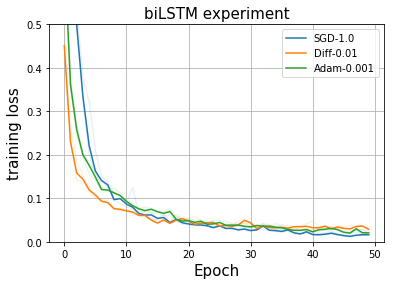

the x axis is not epoch but is 1/5 epoch


In [350]:
# methods = ['AdamC1(1,1)', 'Adam', 'AdamC2(1,1)'] # which variance to use?
# methods = ['AlphaDiff(1,1)', 'AlphaAdam(1,1)', 'SGD'] # what to use?
methods = ['Adam', 'Diff', 'SGD'] # what to use?
# methods = ['AlphaDiff(1,1)', 'AlphaDiff(0,1)', 'AlphaDiff(1,0)'] # what is dominant
# methods = ['AlphaAdam(1,1)', 'AlphaAdam(0,1)', 'AlphaAdam(1,0)'] # what is dominant
# methods = ['Swats', 'AdaBound', 'CrossAdaBound', 'CrossBound'] # when to switch?
# methods = ['AlphaDiff(1,1)', 'AlphaAdam(1,1)', 'CrossBound'] # best comparison
# methods = ['Adam', 'Diff', 'CrossBound'] # best comparison

plot_best('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/bidirectional_recurrent_neural_network/train_loss/*train_losses', 
          title='biLSTM experiment', smooth_window=1, ylim=[0, 0.5], methods=methods)

print('the x axis is not epoch but is 1/5 epoch')

SGD: 89.41% (0.74) 3 runs
Diff: 90.19% (0.45) 3 runs
Adam: 90.07% (0.24) 3 runs


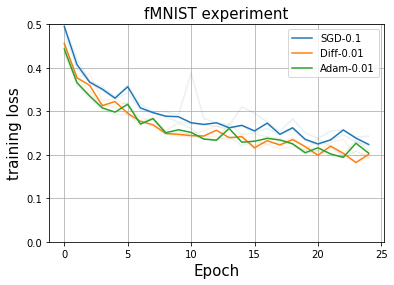

the x axis is not epoch but is 1/5 epoch


In [352]:
# methods = ['AdamC1(1,1)', 'Adam', 'AdamC2(1,1)'] # which variance to use?
# methods = ['AlphaDiff(1,1)', 'AlphaAdam(1,1)', 'SGD'] # what to use?
methods = ['Adam', 'Diff', 'SGD'] # what to use?
# methods = ['AlphaDiff(1,1)', 'AlphaDiff(0,1)', 'AlphaDiff(1,0)'] # what is dominant
# methods = ['AlphaAdam(1,1)', 'AlphaAdam(0,1)', 'AlphaAdam(1,0)'] # what is dominant
# methods = ['Swats', 'AdaBound', 'CrossAdaBound', 'CrossBound'] # when to switch?
# methods = ['AlphaDiff(1,1)', 'AlphaAdam(1,1)', 'CrossAdaBound'] # best comparison
# methods = ['Adam', 'Diff', 'CrossBound'] # best comparison


plot_best('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/fmnist_cnn/train_loss/*train_losses', 
          title='fMNIST experiment', smooth_window=1, ylim=[0, 0.5], methods=methods)

print('the x axis is not epoch but is 1/5 epoch')

Adam: 29.28% (2.47) 36 runs
MomentumCurvature: 29.48% (2.43) 36 runs
SGD: 26.80% (2.90) 35 runs


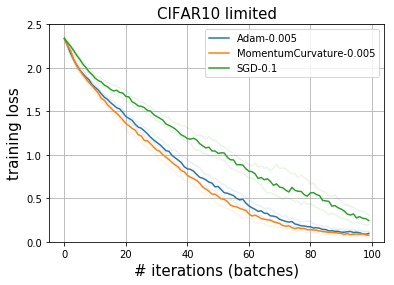

In [456]:
plot_best('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/CIFAR10_limited/train_loss/*train_losses', 
          title='CIFAR10 limited',
          smooth_window=1, ylim=[0,2.5], 
          methods=['SGD', 'MomentumCurvature', 'Adam'],
          #method2label={'MomentumCurvature': 'Proposed'}
         )
#plt.savefig('CIFAR-10', )

Sign: 92.00% (0.00) 5 runs
Avrng: 92.00% (0.00) 5 runs
MomentumCurvature: 92.00% (0.00) 5 runs
Diff: 92.00% (0.00) 5 runs
Adam: 92.00% (0.00) 5 runs
AMSGrad: 92.00% (0.00) 5 runs


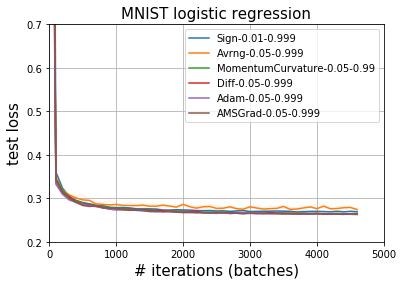

In [772]:
def plot_best_full(pattern, title=None, ylabel=None, ylim=None, xlim=None):
    methods_settings = {}
    accs = {}
    for fn in sorted(glob.glob(pattern)):
        method_setting = fn.split('/')[-1].split('^')[0].split('-')
        method, setting = method_setting[0], '-'.join(method_setting[1:])
        
        if method not in methods_settings:
            methods_settings[method] = {}
            accs[method] = {}
        if setting not in methods_settings[method]:
            methods_settings[method][setting] = []
            accs[method][setting] = []
        
        methods_settings[method][setting].append(joblib.load(fn))
        accs[method][setting].append(float(fn.split('/')[-1].split('^')[1]))
        
    if len(methods_settings.keys()) > 1: # plot the best one, smallest area under the curve
        for method, setting_dict in methods_settings.items():
            setting_areas = []
            for setting, v in setting_dict.items():
                # find the smallest area
                v = list(map(lambda t_val_line: [val for t, val in t_val_line], v))
                area = np.sum(np.mean(v))
                setting_areas.append((setting, area))
            setting = sorted(setting_areas, key=lambda x: x[1])[0][0]
            v = setting_dict[setting]
            t = list(map(lambda t_val_line: [t for t, val in t_val_line], v))
            v = list(map(lambda t_val_line: [val for t, val in t_val_line], v))
            print('{}: {:.2f}% ({:.2f}) {} runs'.format(method, np.mean(accs[method][setting]), 
                                                        np.std(accs[method][setting]),
                                                        len(accs[method][setting])))
            p = plt.plot(t[0], np.percentile(v, 50, 0), label=method + '-' + setting)#, c=colors[i])
            plt.plot(t[0], np.percentile(v, 25, 0), alpha=0.1, c=p[-1].get_color())
            plt.plot(t[0], np.percentile(v, 75, 0), alpha=0.1, c=p[-1].get_color())
            #plt.semilogy(t[0], np.percentile(v, 50, 0), label=k, c=colors[i])
            #plt.semilogy(t[0], np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
            #plt.semilogy(t[0], np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
                        
    else: # plot all
        for method, setting_dict in methods_settings.items():
            for setting, v in setting_dict.items():                
                print('{}: {:.2f}% ({:.2f}) {} runs'.format(method, np.mean(accs[method][setting]), 
                                                            np.std(accs[method][setting]), 
                                                            len(accs[method][setting])))
                
                t = list(map(lambda t_val_line: [t for t, val in t_val_line], v))
                v = list(map(lambda t_val_line: [val for t, val in t_val_line], v))
                
                p = plt.plot(t[0], np.percentile(v, 50, 0), label=method + '-' + setting)#, c=colors[i])
                plt.plot(t[0], np.percentile(v, 25, 0), alpha=0.1, c=p[-1].get_color())
                plt.plot(t[0], np.percentile(v, 75, 0), alpha=0.1, c=p[-1].get_color())
                
                #plt.semilogy(t[0], np.percentile(v, 50, 0), label=k, c=colors[i])
                #plt.semilogy(t[0], np.percentile(v, 25, 0), alpha=0.1, c=colors[i])
                #plt.semilogy(t[0], np.percentile(v, 75, 0), alpha=0.1, c=colors[i])
        
    plt.legend()
    if title:
        plt.title(title, fontsize=15)
    plt.ylim(ylim)
    plt.xlim(xlim)
    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    plt.xlabel('# iterations (batches)', fontsize=15)
    plt.grid()
    plt.show()     

plot_best_full('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/01-basics/logistic_regression/full_loss/*test_losses',  # full_loss
               title='MNIST logistic regression', 
               ylim=[0.2, 0.7], xlim=[-2,5000], ylabel='test loss')

# reproduce marginal value paper

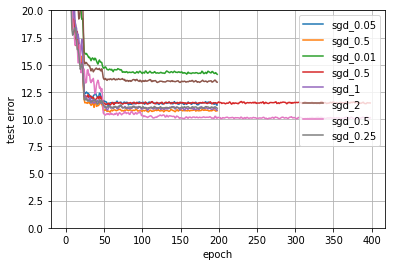

In [814]:
import json
import glob
from lib.utils import smooth

def cifar10_pattern(logs, test=False, ylim=None, acc=True, smooth_window=1, logscale=False):
    if not ylim and acc:
        ylim = [0,20]
    colors = ['r', 'g', 'b', 'k', 'orange', 'pink', 'yellow', 'violet']
    for i, pattern in enumerate(logs):
        for log in glob.glob(pattern):
            name = '_'.join(log.split('/')[-2].split('_')[:2])
            tr_errs = []
            te_errs = []
            with open(log) as f:
                for l in f:
                    d = json.loads(l[len('json_status:'):])
                    if acc:
                        tr_errs.append(100-d['train_acc'])
                        te_errs.append(100-d['test_acc'])
                    else:
                        tr_errs.append(d['train_loss'])
                        tr_errs.append(d['test_loss']) # note no test_loss

                if test:
                    errs = smooth(te_errs, smooth_window)
                else:
                    errs = smooth(tr_errs, smooth_window)
                if len(logs) > 1:
                    if not logscale:
                        plt.plot(errs, label=name, color=colors[i])
                    else:
                        plt.semilogy(errs, label=name, color=colors[i])
                else:
                    if not logscale:
                        plt.plot(errs, label=name)
                    else:
                        plt.semilogy(errs, label=name)
                    
    plt.legend()
    plt.grid()
    #plt.axhline(20, linestyle='--')
    #plt.axvline(10, linestyle='--')
    plt.ylim(ylim)
    plt.ylabel('{} error'.format('test' if test else 'train'))
    plt.xlabel('epoch')
    plt.show()    
        
logs = [
    '../wide-residual-networks/pytorch/logs_25/sgd_*_*/log.txt', # best range [0.25, 0.5*, 1]
    #'../wide-residual-networks/pytorch/logs_25/diff_*_*/log.txt', # best range [0.001, 0.01*, 0.05]
    #'../wide-residual-networks/pytorch/logs_25/adam_*_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    #'../wide-residual-networks/pytorch/logs_25/mc_*_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    #'../wide-residual-networks/pytorch/logs_25/avrng_*_*/log.txt', # best range: [0.01-,0.1*,0.5,1,2]
    #'../wide-residual-networks/pytorch/logs/sign_*_*/log.txt', # need to try smaller values
    #'../wide-residual-networks/pytorch/logs/adamvr_*_*/log.txt',
]
cifar10_pattern(logs, test=True, acc=True, logscale=False, smooth_window=2)

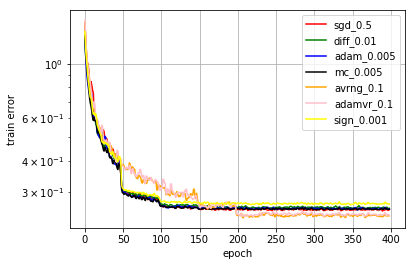

In [826]:
logs = [
    '../wide-residual-networks/pytorch/logs_25/sgd_0.5_13572/log.txt', # best range [0.25, 0.5*, 1]
    '../wide-residual-networks/pytorch/logs_25/diff_0.01_*/log.txt', # best range [0.001, 0.01*, 0.05]
    '../wide-residual-networks/pytorch/logs_25/adam_0.005_*/log.txt', 
    '../wide-residual-networks/pytorch/logs_25/mc_0.005_*/log.txt', 
    '../wide-residual-networks/pytorch/logs_25/avrng_0.1_*/log.txt', # best range: [0.01-,0.1*,0.5,1,2]
    '../wide-residual-networks/pytorch/logs/adamvr_0.1_*/log.txt',
    '../wide-residual-networks/pytorch/logs/sign_0.001_*/log.txt', 
]
cifar10_pattern(logs, test=False, acc=False, logscale=True, smooth_window=2)

# training decay at epoch 60, 120, 160

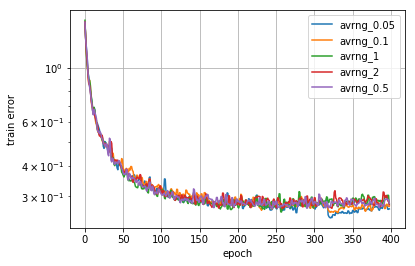

In [825]:
logs = [
    #'../wide-residual-networks/pytorch/logs/sgd_0.5_*/log.txt', # best range [0.25, 0.5*, 1]
    #'../wide-residual-networks/pytorch/logs/vanillaSGD_*_*/log.txt',
    #'../wide-residual-networks/pytorch/logs/adam_*_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    #'../wide-residual-networks/pytorch/logs/mc_*_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    '../wide-residual-networks/pytorch/logs/avrng_*_*/log.txt', # best range: [0.05,0.1*,0.5,1,2]
]
cifar10_pattern(logs, test=False, acc=False, logscale=True, smooth_window=2)

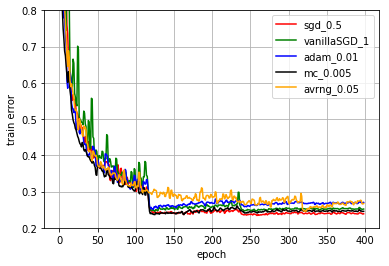

In [873]:
logs = [
    '../wide-residual-networks/pytorch/logs/sgd_0.5_*/log.txt', # best range [0.25, 0.5*, 1]
    '../wide-residual-networks/pytorch/logs/vanillaSGD_1_*/log.txt',
    '../wide-residual-networks/pytorch/logs/adam_0.01_*/log.txt', # best range [0.001, 0.005*, 0.01*, 0.05]
    '../wide-residual-networks/pytorch/logs/mc_0.005_*/log.txt', 
    '../wide-residual-networks/pytorch/logs/avrng_0.05_*/log.txt', # need to try smaller values
]
cifar10_pattern(logs, test=False, ylim=[0.2,0.8], acc=False, logscale=False, smooth_window=2)